## Näslund height curve

Checking where parameters are coming from...

Samuli Launiainen 6.4.2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Code below from my original codes (in ACGCA branch 'main'): https://github.com/LukeEcomod/ACGCA/blob/main/productivity/vegetation.py

In [2]:
def naslund_heightcurve(d, species, p=None):
    """
    Computes tree height from dbh using Näslund -equation parameterized by
    Siipilehto & Kangas, 2015 Metsätalouden Aikakausikirja Table 3
    Args:
        d - DBH, diameter at breast height (cm)
        species - 'pine', 'spruce', 'birch'
    Returns:
        z - scalar or array of tree heights (m)
    """
    para = {'pine': [2.0, 1.181, 0.247], 'spruce': [3.0, 1.703, 0.327], 'birch': [2.0, 1.014, 0.238]}
    if p is None:    
        p = para[species]
    
    z = 1.3 + d**p[0] / ( p[1] + p[2]*d)**p[0]

    return z    

### The above height curve parameters are from Siipilehto & Kangas (2015) Table 3; they refer to Kangas & Maltamo (2000). That paper is based on large number of trees from NFI permanent sample plots. And thus should be quite generic...

Kangas, A. & Maltamo, M. 2002. Anticipating the variance of predicted stand volume and timber assortments
with respect to stand characteristics and field measurements. Silva Fennica 36(4): 799–811. https://doi.org/10.14214/sf.522

In [3]:
# in ACGCA the used parameters are based on fitting to tree-inventory data from Hyytiälä (in 2008) / Samuli

#params_crown = {
#    "pine": {"k": 2, "a": 1.108, "b": 0.197, "c": 3.0, "d": 0.76},
#    "spruce": {"k": 3, "a": 1.826, "b": 0.303, "c": 2.34, "d": 0.58},
#    "birch": {"k": 2, "a": 0.674, "b": 0.201, "c": 2.34, "d": 0.58},
#}

# This is based on my fitting to tree inventory data from Hyytiälä -stand AND CURRENTLY USED IN ACGCA -paper!!!
para = {'pine': [2.0, 1.108, 0.197], 
       'spruce': [3.0, 1.826, 0.303],
       'birch': [2.0, 0.674, 0.201]
       }

# Siipilehto 200x Silva Fennica - using NFI data from >100 plots

paras = {'pine': [2.0, 0.8944444, 0.185], 
       'spruce': [3.0, 1.811, 0.308]
       }

## Compare Siipilehto & Kangas (2015), Siipilehto (2000) vs. our current parameterization

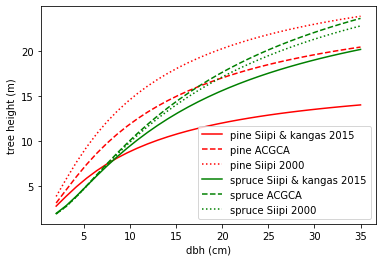

In [4]:
%matplotlib inline

dbh = np.linspace(2, 35, 31) # cm

spec = ['pine', 'spruce']
z_acgca = []
z_siipi = []
fig, ax = plt.subplots(1)
col = ['r','g', 'b']
k = 0
for s in spec:
    z_acgca = naslund_heightcurve(dbh, s, p=None)
    z_sk = naslund_heightcurve(dbh, s, p=para[s])
    z_sii = naslund_heightcurve(dbh, s, p=paras[s])
    ax.plot(dbh, z_acgca, '-', color=col[k], label=s + ' Siipi & kangas 2015')
    ax.plot(dbh, z_sk, '--', color=col[k], label=s + ' ACGCA')
    ax.plot(dbh, z_sii, ':', color=col[k], label=s + ' Siipi 2000')
    k += 1
ax.set_ylabel('tree height (m)')
ax.set_xlabel('dbh (cm)')
ax.legend()

### It seems our parameterization (based on Hyytiälä) for spruce is similar to S2000 & SK2015. The parameterization for pine falls in between the other estimates. Spruce-pine heights intersect at dbh ~17cm.

### Should we test if Siipilehto (2000) parameters are used? Expect it will affect pine radial growth slightly, and can also change the comepetition patterns in young stands.

### Change in trunk shape may also affect allocation between long vs. short-term wood products.

## Trunk shape and trunk base height are based on Tahvanainen & Forss (2005)

In [5]:
def crownheight(h, species):
    """
    Computes crown height from relationships derived from Tahvanainen & Forss, 2008 For. Ecol. Manag.
    Fig 4
    Args:
        h - height (m)
    Returns:
        ht - height to crown base
    """
    
    if species == 'pine':
        ht = -3.0 + 0.76*h
        ht = np.maximum(0.0, ht)
    if species == 'spruce':
        ht = -1.99 + 0.51*h - 7.7e-3*h**2.0
        #ht = -1.99 + 0.56*h IS NEARLY SAME AS ABOVE!
        ht = np.maximum(0.0, ht)
    if species == 'birch':
        ht = -2.23 + 0.58*h
        ht = np.maximum(0.0, ht)

    return ht

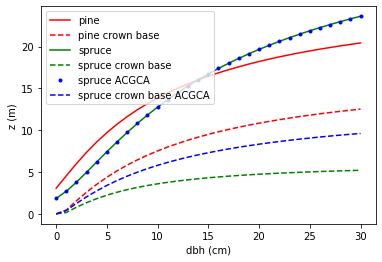

In [6]:
# obtain crown heights or pine and spruce

# heights using our current parameterization
z_pine = naslund_heightcurve(dbh, 'pine', p=para['pine'])
c_pine = crownheight(z_pine, 'pine')

z_spruce = naslund_heightcurve(dbh, 'spruce', p=para['spruce'])
c_spruce = crownheight(z_pine, 'spruce')

fig, ax = plt.subplots()
ax.plot(z_pine, 'r-', label='pine')
ax.plot(c_pine, 'r--', label='pine crown base')
ax.plot(z_spruce, 'g-', label='spruce')
ax.plot(c_spruce, 'g--', label='spruce crown base')

# but, we seem to use crown base height parameter from birch currently for spruce...
# this is likely due to typo in my old code (profiles_hyde, see below) you have converted in ACGCA
c_spruce_acgca = crownheight(z_pine, 'birch')
ax.plot(z_spruce, 'b.', label='spruce ACGCA')
ax.plot(c_spruce_acgca, 'b--', label='spruce crown base ACGCA')
ax.set_ylabel('z (m)')
ax.set_xlabel('dbh (cm)')
ax.legend()

# to recover true spruce crown base (blue dashed line) use
params_crown = {
    "pine": {"k": 2, "a": 1.108, "b": 0.197, "c": 3.0, "d": 0.76},
    #"spruce": {"k": 3, "a": 1.826, "b": 0.303, "c": 2.34, "d": 0.58}, # good approximation
    "spruce": {"k": 3, "a": 1.826, "b": 0.303, "c": 1.99, "d": 0.56},
    "birch": {"k": 2, "a": 0.674, "b": 0.201, "c": 2.34, "d": 0.58},
}


### Values used in our simulations seem again be based on Hyytiälä stand inventory data from 2008

See function below; from ACGCA branch 'main'; productivity --> vegetation.py


In [7]:
# this is my old code, from which you have adapted ACGCA -functions. I believe I have here typo for computing
# spruce crown height

def profiles_hyde(data, species, z):
    """
    height h model based on Näslund equation parameterized using Hyytiälä stand inventory from 2008
    trunk base ht model based on Tahvanainen & Forss, 2008 For. Ecol. Manag. Fig 4:
    Returns:
        h - height (m)
        ht - crown base height (m)
        mleaf - leaf mass (kg)
        N - trees ha-1
        lad - leaf-area density (m2m-1), integrates to 1
        
    """
    d = data[:,0]  # dbh, cm
    N = data[:,1]  # trees ha-1
   
    # compute 
    if species == 'pine':
        h = 1.3 + d**2.0 / (1.108 + 0.197*d)**2.0
        ht = -3.0 + 0.76*h
        ht = np.maximum(0.0, ht)
        
        y, L = marklund(d, species)
        mleaf = y[3]  # kg
        #L = L # leaf area m2
        
    if species == 'birch':
        h = 1.3 + d**2.0 / (0.674 + 0.201*d)**2.0
        ht = -2.34 + 0.58*h
        ht = np.maximum(0.0, ht)

        y, L = marklund(d, species)
        mleaf = y[3]  # kg
        
    if species == 'spruce':
        h = 1.3 + d**3.0 / (1.826 + 0.303*d)**3.0
        # THESE LINES SHOULD BE:
        # ht = -2.34 + 0.58*h
        # ht = np.maximum(0.0, ht)  
        ht = -1.99 + 0.51*h - 7.7e-3*h**2.0
        #above is closely equivalent to 
        # ht = -1.99 + 0.56*h
        ht = np.maximum(0.0, ht)      

        y, L = marklund(d, species)
        mleaf = y[3]  # kg

    
    # get crown leaf mass profiles
    lad = np.zeros([len(z),len(d)])
    for k in range(len(d)):
        a, _ = crown_biomass_distr(species,z,htop=h[k],hbase=ht[k])
        lad[:,k] =a*L[k]
    
    return h, ht, mleaf, N, lad